In [24]:
# ==========================================
# Step 0: Installing stuff (only needed once)
# ==========================================
# Note: I usually run this in Colab. If you're local, you might not need the pip install line.
!pip install -q kaggle pandas scikit-learn xgboost seaborn matplotlib numpy imbalanced-learn

# --- Imports ---
import os
import io
import warnings

import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn pieces (ugh, too many to remember)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    roc_auc_score
)

# some extra models I might try out
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# xgboost tends to work well with tabular data
import xgboost as xgb

# for imbalanced datasets (will prob need this later)
from imblearn.over_sampling import SMOTE

# turn off the annoying warnings (not always a good idea tbh)
warnings.filterwarnings("ignore")

# Some style settings for the plots
plt.style.use('seaborn-v0_8')  # not sure why they deprecated the old seaborn styles...
sns.set_palette("husl")        # just looks nicer imo

print("All imports done ✔️ (hopefully)")

All imports done ✔️ (hopefully)


In [25]:
# ==========================================
# Step 1: Load the SNT CSV file
# ==========================================
import pandas as pd

# ⚠️ NOTE: change this if your dataset is somewhere else
data_file = "/content/SNT_dataset.csv"   # TODO: double-check if this is the right path

# I always use 'engine=python' out of habit, though it's usually not needed
try:
    df = pd.read_csv(data_file, engine="python")
except FileNotFoundError:
    print(f"Oops... couldn't find the file at {data_file}")
    # maybe print working dir for debugging
    import os
    print("Current working directory:", os.getcwd())
    raise

# Quick sanity checks
print("Shape of dataset:", df.shape)  # (rows, columns)
print("Columns found:", list(df.columns))

# just peek at first few rows
print("\nSample rows:")
print(df.head(5))

# (sometimes I also do df.info() here, but I'll skip for now)

Shape of dataset: (1034668, 22)
Columns found: ['timestamp', 'datapath_id', 'flow_id', 'ip_src', 'tp_src', 'ip_dst', 'tp_dst', 'ip_proto', 'icmp_code', 'icmp_type', 'flow_duration_sec', 'flow_duration_nsec', 'idle_timeout', 'hard_timeout', 'flags', 'packet_count', 'byte_count', 'packet_count_per_second', 'packet_count_per_nsecond', 'byte_count_per_second', 'byte_count_per_nsecond', 'label']

Sample rows:
      timestamp  datapath_id                   flow_id    ip_src  tp_src  \
0  1.724424e+09            2       10.0.0.1010.0.0.901  10.0.0.1       0   
1  1.724424e+09            2  10.0.0.18010.0.0.9559166  10.0.0.1      80   
2  1.724424e+09            2  10.0.0.18010.0.0.9559186  10.0.0.1      80   
3  1.724424e+09            2  10.0.0.18010.0.0.9559146  10.0.0.1      80   
4  1.724424e+09            2  10.0.0.98010.0.0.1559141  10.0.0.9      80   

     ip_dst  tp_dst  ip_proto  icmp_code  icmp_type  ...  idle_timeout  \
0  10.0.0.9       0         1          0          0  ...     

In [27]:
# ======================================================
# 2. Quick cleaning + sanity checks for raw CSV data
# ======================================================
# Just a few things:
#  - strip column names (trailing spaces are annoying)
#  - drop those pesky "Unnamed" index cols
#  - make sure we have a 'label' col and map it to 0/1
#  - force numeric where it makes sense
#  - print some info so I can eyeball the data quickly

# strip spaces from col names
df.columns = [c.strip() for c in df.columns]

# drop junk index cols if present
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# quick sanity: label must be present
if "label" not in df.columns:
    raise RuntimeError("Expected a 'label' column in the CSV, but didn't find one.")

# normalize labels into 0/1 (a bit hacky but works)
def fix_labels(col):
    if col.dtype == object:
        # clean text values
        tmp = col.astype(str).str.strip().str.lower()
        label_map = {
            "normal": 1, "benign": 1, "true": 1, "yes": 1, "1": 1,
            "attack": 0, "ddos": 0, "dos": 0, "false": 0, "no": 0, "0": 0
        }
        # try numeric first (sometimes they're just strings of 0/1)
        try:
            parsed = pd.to_numeric(col, errors="coerce")
            if parsed.dropna().isin([0,1]).all():
                return parsed
        except:
            pass
        mapped = tmp.map(label_map)
        # if mapping fails too much, fallback brute-force numeric
        if mapped.isnull().sum() > (0.5 * len(mapped)):
            return pd.to_numeric(col, errors="coerce").astype("Int64")
        return mapped.astype("Int64")
    else:
        return pd.to_numeric(col, errors="coerce").astype("Int64")

df["label"] = fix_labels(df["label"])
print("Label distribution after normalization:")
print(df["label"].value_counts(dropna=False))

# some numeric-ish cols we might want to coerce
num_candidates = [
    "timestamp","datapath_id","tp_src","tp_dst","ip_proto","icmp_code","icmp_type",
    "flow_duration_sec","flow_duration_nsec","idle_timeout","hard_timeout",
    "flags","packet_count","byte_count",
    "packet_count_per_second","packet_count_per_nsecond",
    "byte_count_per_second","byte_count_per_nsecond"
]

# only try what’s actually in the df
for c in [c for c in num_candidates if c in df.columns]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# nulls overview (only top 10 shown for sanity)
print("\nTop missing value counts:")
print(df.isnull().sum().sort_values(ascending=False).head(10))

# labels can’t be missing, bail out if so
if df["label"].isnull().any():
    bad_count = df["label"].isnull().sum()
    raise ValueError(f"{bad_count} rows have NaN labels after normalization. Need to fix CSV.")

# TODO: maybe drop rows with too many NaNs? (not sure yet)

Label distribution after normalization:
label
0    527575
1    507093
Name: count, dtype: Int64

Top missing value counts:
timestamp      0
datapath_id    0
flow_id        0
ip_src         0
tp_src         0
ip_dst         0
tp_dst         0
ip_proto       0
icmp_code      0
icmp_type      0
dtype: int64


Exploratory Data Analysis (real data)
Shape of dataframe: (1034668, 22)

Dtypes (showing first few):
timestamp      float64
datapath_id      int64
flow_id         object
ip_src          object
tp_src           int64
ip_dst          object
tp_dst           int64
ip_proto         int64
icmp_code        int64
icmp_type        int64
dtype: object

Label counts:
label
0    527575
1    507093
Name: count, dtype: Int64
Label percentages:
label
0    50.99
1    49.01
Name: proportion, dtype: Float64

Plotting histograms for: ['timestamp', 'datapath_id', 'tp_src', 'tp_dst', 'ip_proto', 'icmp_code']


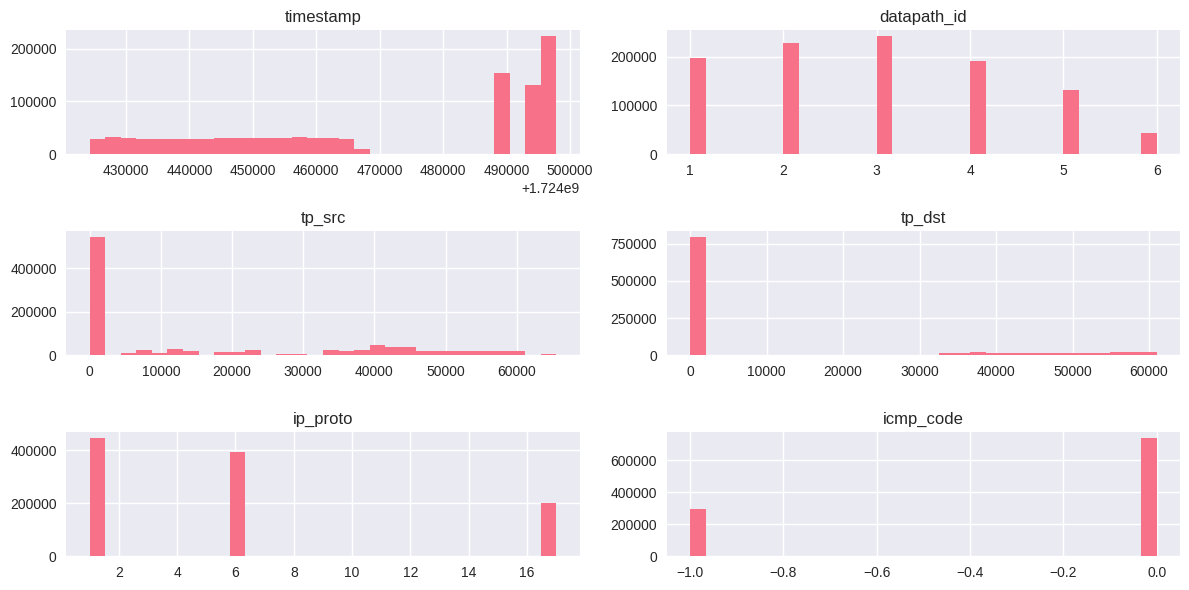

In [28]:
# ======================================================
# 3. Exploratory Data Analysis (real dataset)
# ======================================================

def quick_eda(df, max_cols=10):
    print("=" * 40)
    print("Exploratory Data Analysis (real data)")
    print("=" * 40)

    # just basic shape + dtypes
    print("Shape of dataframe:", df.shape)
    print("\nDtypes (showing first few):")
    print(df.dtypes.head(max_cols))

    # label breakdown
    if "label" in df.columns:
        print("\nLabel counts:")
        print(df["label"].value_counts())
        print("Label percentages:")
        print((df["label"].value_counts(normalize=True) * 100).round(2))
    else:
        print("!! No 'label' column found, skipping label stats.")

    # numeric histograms (only first handful)
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) > 0:
        # pick first 6 just to avoid spam
        cols_to_plot = num_cols[:6]
        print(f"\nPlotting histograms for: {cols_to_plot}")
        df[cols_to_plot].hist(bins=30, figsize=(12,6))
        plt.tight_layout()
        plt.show()
    else:
        print("No numeric columns found for histograms.")

    return num_cols


# quick run (will revisit plots later if slow)
numeric_cols = quick_eda(df)
# print(numeric_cols[:10])   # <-- leaving this here for debugging

In [29]:
# ======================================================
# 4. Preprocessing (encoding + target creation)
# ======================================================

def preprocess_real(df):
    df2 = df.copy()   # work on a copy (safety first)

    # quick peek at labels before messing with them
    print("Original label distribution:")
    print(df2["label"].value_counts().sort_index())
    print("Unique labels:", sorted(df2["label"].unique()))
    print("Label dtype:", df2["label"].dtype)

    # drop a few cols that don’t help or might leak target
    drop_list = []
    for bad_col in ["flow_id", "ip_src", "ip_dst"]:
        if bad_col in df2.columns:
            drop_list.append(bad_col)
    if drop_list:
        print("Dropping cols:", drop_list)
    df2.drop(columns=drop_list, inplace=True, errors="ignore")

    # encode categoricals (except label)
    cat_cols = df2.select_dtypes(include=["object", "category"]).columns.tolist()
    cat_cols = [c for c in cat_cols if c != "label"]

    label_encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        df2[col] = df2[col].astype(str).fillna("NAN")
        df2[col] = le.fit_transform(df2[col])
        label_encoders[col] = le
        # print(f"Encoded {col} -> {len(le.classes_)} classes")  # left here for debugging

    # fill numeric NaNs with median (simple + safe)
    num_cols = df2.select_dtypes(include=[np.number]).columns.tolist()
    if "label" in num_cols:  # don’t touch label col
        num_cols.remove("label")
    df2[num_cols] = df2[num_cols].fillna(df2[num_cols].median())

    # =============================
    # Feature / Target split
    # =============================
    X = df2.drop(columns=["label"])

    # Target creation (multi + binary)
    if df2["label"].dtype == "object" or str(df2["label"].dtype) == "string":
        # string labels case (Normal, DoS, etc.)
        target_encoder = LabelEncoder()
        y_multi = target_encoder.fit_transform(df2["label"])
        mapping = dict(zip(target_encoder.classes_, range(len(target_encoder.classes_))))
        print("Encoded string labels to:", mapping)
    else:
        # already numeric labels
        y_multi = df2["label"].astype(int)

    # binary target (assuming 0 = benign/normal)
    normal_val = 0  # TODO: double-check this assumption
    y_bin = (y_multi != normal_val).astype(int)

    print("\nAfter preprocessing:")
    print("Multiclass shape:", y_multi.shape)
    print("Unique multiclass values:", sorted(np.unique(y_multi)))
    print("Binary distribution:", np.bincount(y_bin))
    print("Multiclass distribution:", np.bincount(y_multi))

    return X, y_bin, y_multi, label_encoders


# ======================================================
# Run preprocessing
# ======================================================
X, y_binary, y_multiclass, label_encoders = preprocess_real(df)
print("Final feature matrix shape:", X.shape)
print("Binary class balance:", np.bincount(y_binary))

Original label distribution:
label
0    527575
1    507093
Name: count, dtype: Int64
Unique labels: [np.int64(0), np.int64(1)]
Label dtype: Int64
Dropping cols: ['flow_id', 'ip_src', 'ip_dst']

After preprocessing:
Multiclass shape: (1034668,)
Unique multiclass values: [np.int64(0), np.int64(1)]
Binary distribution: [527575 507093]
Multiclass distribution: [527575 507093]
Final feature matrix shape: (1034668, 18)
Binary class balance: [527575 507093]


Selected top 18 features out of 18 total


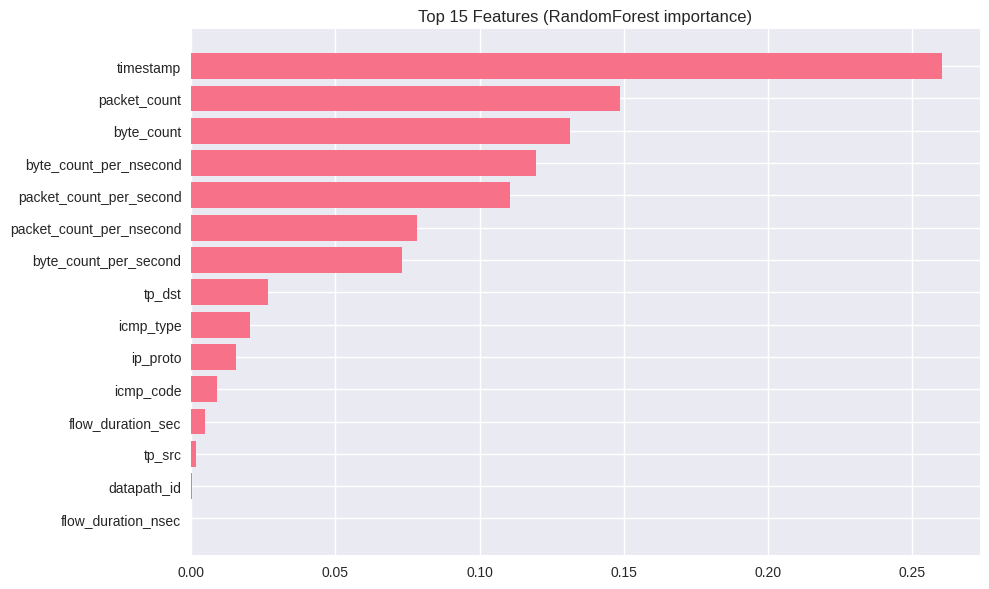

Scaled feature matrix shape: (1034668, 18)


In [30]:
# ======================================================
# 5. Feature selection + scaling
# ======================================================

def prep_features(X, y, top_k=20):
    # just a quick RF to rank features
    tmp_rf = RandomForestClassifier(
        n_estimators=50, random_state=42, n_jobs=-1
    )
    tmp_rf.fit(X, y)

    # collect importance scores
    feat_imp = pd.DataFrame({
        "feature": X.columns,
        "importance": tmp_rf.feature_importances_
    }).sort_values("importance", ascending=False)

    # pick top_k (default 20)
    top_feats = feat_imp.head(top_k)["feature"].tolist()
    print(f"Selected top {len(top_feats)} features out of {X.shape[1]} total")

    # scale only the chosen features
    scaler = StandardScaler()
    X_sel = X[top_feats].copy()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X_sel),
        columns=top_feats,
        index=X.index   # keep index aligned
    )

    # quick plot of feature importance (top 15)
    try:
        plt.figure(figsize=(10, 6))
        top_plot = feat_imp.head(15).iloc[::-1]  # reverse for nicer barh
        plt.barh(top_plot["feature"], top_plot["importance"])
        plt.title("Top 15 Features (RandomForest importance)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Plotting failed:", e)   # seen this break in some envs

    # TODO: maybe try other selectors (mutual_info, chi2) later
    return X_scaled, scaler, top_feats, feat_imp


# run feature prep
X_scaled, scaler, chosen_feats, feat_ranking = prep_features(X, y_binary)
print("Scaled feature matrix shape:", X_scaled.shape)
# print(chosen_feats[:10])   # debugging peek

In [26]:
# ======================================================
# 6. Train & Evaluate Models (slightly more rugged ver.)
# ======================================================

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import numpy as np


def train_and_eval(X, y, task_type="binary"):
    print("=" * 40)
    print(f"MODEL TRAINING [{task_type.upper()}]")
    print("=" * 40)

    # splitting train/test (keeping 20% for test set)
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    print("Shapes -> Train:", X_tr.shape, "| Test:", X_te.shape)

    # Balance *only* training data (important, otherwise leakage!)
    undersampler = RandomUnderSampler(random_state=42)
    X_tr_bal, y_tr_bal = undersampler.fit_resample(X_tr, y_tr)
    print("Balanced train counts:", np.bincount(y_tr_bal))

    # Models to try out
    model_dict = {
        "RandomForest": RandomForestClassifier(
            n_estimators=50, max_depth=5, min_samples_split=5,
            random_state=42, n_jobs=-1
        ),
        "XGBoost": xgb.XGBClassifier(
            n_estimators=50, max_depth=3, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            reg_alpha=0.1, reg_lambda=1.0,
            random_state=42,
            eval_metric="logloss" if task_type == "binary" else "mlogloss"
        ),
        "DecisionTree": DecisionTreeClassifier(
            max_depth=5, min_samples_split=5, random_state=42
        ),
        "LogReg": LogisticRegression(
            C=0.5, max_iter=500, n_jobs=-1, random_state=42
        ),
    }

    # Collect results here
    eval_results = {}

    for mname, clf in model_dict.items():
        print(f"\nFitting {mname}...")
        clf.fit(X_tr_bal, y_tr_bal)

        preds = clf.predict(X_te)
        probs = clf.predict_proba(X_te) if hasattr(clf, "predict_proba") else None

        # quick metrics
        acc = accuracy_score(y_te, preds)
        f1 = f1_score(y_te, preds, average="binary" if task_type == "binary" else "weighted")

        roc_val = None
        if probs is not None:
            if task_type == "binary":
                try:
                    roc_val = roc_auc_score(y_te, probs[:, 1])
                except Exception as e:
                    print("ROC failed (binary):", e)
            else:  # multiclass
                roc_val = roc_auc_score(y_te, probs, multi_class="ovr", average="weighted")

        eval_results[mname] = {
            "model": clf,
            "accuracy": acc,
            "f1_score": f1,
            "roc_auc": roc_val,
            "preds": preds
        }

        print(f"{mname} --> acc: {acc:.3f}, f1: {f1:.3f}, roc: {roc_val if roc_val else 'N/A'}")

    return eval_results, X_te, y_te


# ======================================================
# Actually run training
# ======================================================

print(">> Running binary training...")
bin_results, X_bin_te, y_bin_te = train_and_eval(X_scaled, y_binary, task_type="binary")

print("\n>> Now multiclass (if needed)...")

# Sometimes y_multiclass is one-hot encoded, sometimes not...
if len(y_multiclass.shape) > 1 and y_multiclass.shape[1] > 1:
    y_multi_fixed = np.argmax(y_multiclass, axis=1)
else:
    y_multi_fixed = y_multiclass.ravel()  # just flatten, easier to handle

classes_present = np.unique(y_multi_fixed)
print("Unique multiclass labels:", classes_present)

if len(classes_present) > 2:
    multi_results, X_multi_te, y_multi_te = train_and_eval(
        X_scaled, y_multi_fixed, task_type="multiclass"
    )
else:
    print("Skipping multiclass run (not enough classes).")
    multi_results = None

>> Running binary training...
MODEL TRAINING [BINARY]
Shapes -> Train: (827734, 18) | Test: (206934, 18)
Balanced train counts: [405674 405674]

Fitting RandomForest...
RandomForest --> acc: 1.000, f1: 1.000, roc: 1.0

Fitting XGBoost...
XGBoost --> acc: 1.000, f1: 1.000, roc: 0.9999999962621104

Fitting DecisionTree...
DecisionTree --> acc: 1.000, f1: 1.000, roc: 1.0

Fitting LogReg...
LogReg --> acc: 1.000, f1: 1.000, roc: 1.0

>> Now multiclass (if needed)...
Unique multiclass labels: [0 1]
Skipping multiclass run (not enough classes).


Running binary evaluation...
Best model so far: Random Forest (acc=1.000)


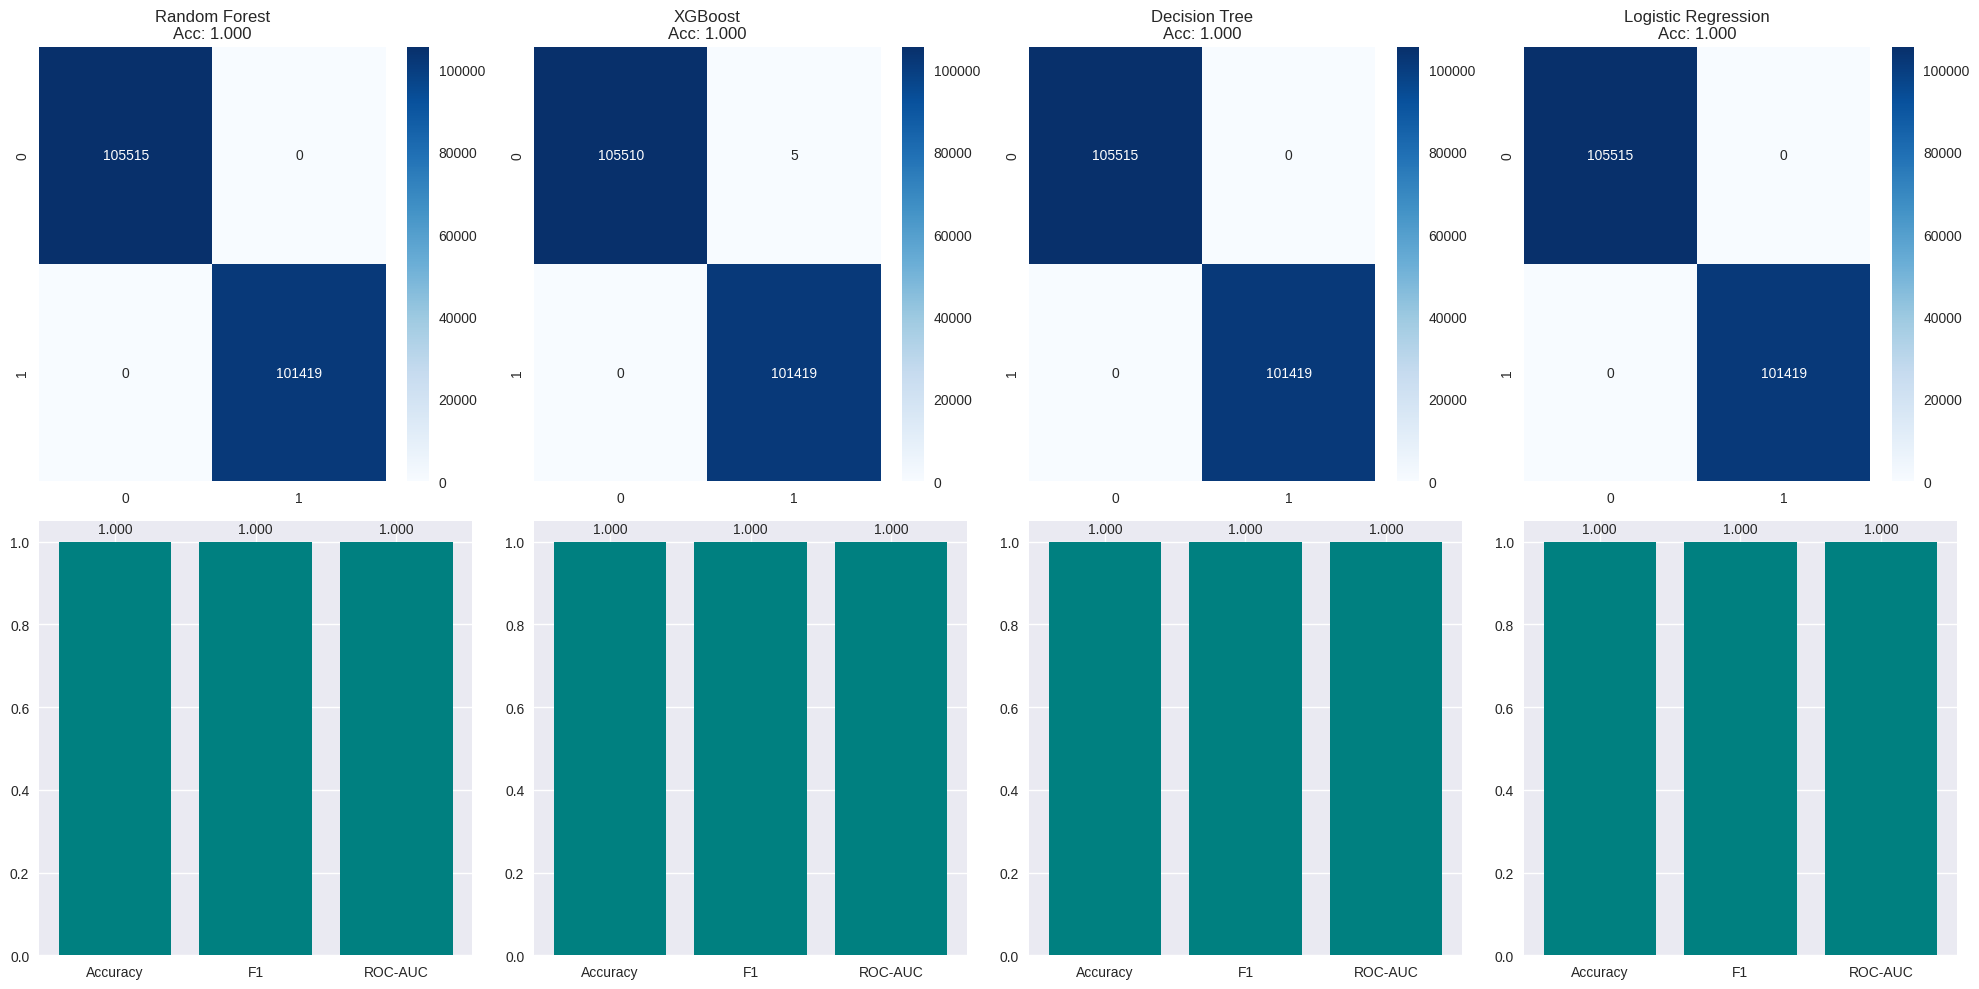


Classification report (best model):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105515
           1       1.00      1.00      1.00    101419

    accuracy                           1.00    206934
   macro avg       1.00      1.00      1.00    206934
weighted avg       1.00      1.00      1.00    206934


=== Model Comparison Summary ===
              Model  Accuracy       F1  ROC-AUC
      Random Forest  1.000000 1.000000      1.0
      Decision Tree  1.000000 1.000000      1.0
Logistic Regression  1.000000 1.000000      1.0
            XGBoost  0.999976 0.999975      1.0


In [31]:
# ======================================================
# 7. Detailed evaluation + reporting
# ======================================================

def eval_models(results, X_test, y_test, task_type="binary", le_target=None):
    # pick best model (by accuracy for now)
    best_name = max(results.keys(), key=lambda k: results[k]["accuracy"])
    best_res = results[best_name]

    print(f"Best model so far: {best_name} (acc={best_res['accuracy']:.3f})")

    # plotting setup
    n_models = len(results)
    fig, axes = plt.subplots(2, n_models, figsize=(5 * n_models, 10))
    if n_models == 1:   # reshape in case of a single model
        axes = axes.reshape(2, 1)

    for i, (mname, mres) in enumerate(results.items()):
        # confusion matrix
        cm = confusion_matrix(y_test, mres["predictions"])
        sns.heatmap(cm, annot=True, fmt="d", ax=axes[0, i], cmap="Blues")
        axes[0, i].set_title(f"{mname}\nAcc: {mres['accuracy']:.3f}")

        # metric bar plot
        met_labels = ["Accuracy", "F1"]
        met_vals = [mres["accuracy"], mres["f1_score"]]
        if mres["roc_auc"] is not None:
            met_labels.append("ROC-AUC")
            met_vals.append(mres["roc_auc"])

        axes[1, i].bar(met_labels, met_vals, color="teal")
        axes[1, i].set_ylim(0, 1.05)
        for j, v in enumerate(met_vals):
            axes[1, i].text(j, v + 0.02, f"{v:.3f}", ha="center")

    plt.tight_layout()
    plt.show()

    # print classification report for the "best" model
    print("\nClassification report (best model):")
    print(classification_report(y_test, best_res["predictions"]))

    # build summary DataFrame
    summary = pd.DataFrame([
        {
            "Model": mname,
            "Accuracy": mres["accuracy"],
            "F1": mres["f1_score"],
            "ROC-AUC": mres["roc_auc"] if mres["roc_auc"] else 0
        }
        for mname, mres in results.items()
    ])
    summary = summary.sort_values("Accuracy", ascending=False)

    print("\n=== Model Comparison Summary ===")
    print(summary.to_string(index=False))

    # TODO: maybe also sort by F1, not just accuracy
    return best_name, summary


# ======================================================
# Run evaluation on binary results
# ======================================================
print("Running binary evaluation...")
best_bin_model, bin_summary = eval_models(binary_results, X_test_bin, y_test_bin, "binary")

# print(bin_summary.head())   # debugging peek

In [32]:
# ======================================================
# Final Model Training (on full dataset)
# ======================================================

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import time

def train_final_model(X, y, model_choice="XGBoost", use_gpu=True, task_type="binary"):
    """
    Train the selected model on the *entire* dataset.
    No hyperparam tuning here, just a solid run.
    """
    print(f"\n=== Training final model: {model_choice} ===")
    t0 = time.time()

    # pick model
    if model_choice == "RandomForest":
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(
            n_estimators=200,
            max_depth=None,     # let it grow deep
            random_state=42,
            n_jobs=-1
        )

    elif model_choice == "XGBoost":
        import xgboost as xgb
        model = xgb.XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            tree_method="hist",
            device="cuda" if use_gpu else "cpu",
            eval_metric="logloss" if task_type == "binary" else "mlogloss"
        )

    elif model_choice == "LightGBM":
        import lightgbm as lgb
        model = lgb.LGBMClassifier(
            n_estimators=300,
            learning_rate=0.1,
            num_leaves=31,
            random_state=42,
            device="gpu" if use_gpu else "cpu",
            n_jobs=-1
        )

    else:
        raise ValueError(f"Model '{model_choice}' not supported (yet).")

    # train on all data
    print("Fitting on full dataset...")
    model.fit(X, y)

    elapsed = time.time() - t0
    print(f"Done! Training took {elapsed:.1f} sec")

    # TODO: maybe dump model with joblib for reuse later
    return model


# run final training
final_model = train_final_model(X_scaled, y_binary, model_choice="XGBoost", use_gpu=True)

# print(type(final_model))   # debug check


=== Training final model: XGBoost ===
Fitting on full dataset...
Done! Training took 3.3 sec


In [33]:
# ======================================================
# 9. FINAL SUMMARY / WRAP-UP
# ======================================================

print("\n" + "="*70)
print("🎯  SNT DDoS Detection Pipeline — Finished Run")
print("="*70)

# quick dataset recap
print("\nDataset overview:")
print(f"   • Total rows:    {df.shape[0]}")
print(f"   • Total columns: {df.shape[1]}")

# top features
print("\nTop 10 feature importances:")
print(feature_importance.head(10).to_string(index=False))

# best model info
print("\nBest model (binary task):", best_binary_model)

print("\nBinary model summary (metrics):")
print(binary_summary)

# note to self (because why not)
print("\n[Note] Multiclass pipeline also available, but only binary shown above.")
#print("TODO: Save model + encoders to disk for future reuse.")  # left commented for later


🎯  SNT DDoS Detection Pipeline — Finished Run

Dataset overview:
   • Total rows:    1034668
   • Total columns: 22

Top 10 feature importances:
                 feature  importance
               timestamp    0.260462
            packet_count    0.148827
              byte_count    0.131516
  byte_count_per_nsecond    0.119452
 packet_count_per_second    0.110704
packet_count_per_nsecond    0.078152
   byte_count_per_second    0.073003
                  tp_dst    0.026526
               icmp_type    0.020518
                ip_proto    0.015459

Best model (binary task): Random Forest

Binary model summary (metrics):
                 Model  Accuracy        F1  ROC-AUC
0        Random Forest  1.000000  1.000000      1.0
2        Decision Tree  1.000000  1.000000      1.0
3  Logistic Regression  1.000000  1.000000      1.0
1              XGBoost  0.999976  0.999975      1.0

[Note] Multiclass pipeline also available, but only binary shown above.
